##### Initialization

In [1]:
import os, tensorflow as tf, matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns, time
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
gpu = tf.config.experimental.list_physical_devices('GPU')

for g in gpu:
    tf.config.experimental.set_memory_growth(g, True)

In [3]:
img_height, img_width = 256, 256
batch_size = 32
random_seed = 1337
split_ratio = 0.35

train_dataset = tf.keras.preprocessing.image_dataset_from_directory('../data',
                                                                    validation_split=None,
                                                                    subset=None,
                                                                    seed=random_seed,
                                                                    label_mode='int',
                                                                    color_mode='rgb',
                                                                    image_size=(img_height, img_width),
                                                                    batch_size=batch_size)

# train_dataset = tf.keras.preprocessing.image_dataset_from_directory('../data',
#                                                                     validation_split=split_ratio,
#                                                                     subset='training',
#                                                                     seed=random_seed,
#                                                                     label_mode='int',
#                                                                     color_mode='rgb',
#                                                                     image_size=(img_height, img_width),
#                                                                     batch_size=batch_size)

# val_dataset = tf.keras.preprocessing.image_dataset_from_directory('../data',
#                                                                     validation_split=split_ratio,
#                                                                     subset="validation",
#                                                                     seed=random_seed,                                                                  
#                                                                     label_mode='int',
#                                                                     color_mode='rgb',
#                                                                     image_size=(img_height, img_width),
#                                                                     batch_size=batch_size)

class_names = train_dataset.class_names
print(f'Class names: {class_names}')

Found 2440 files belonging to 8 classes.
Class names: ['body', 'conditioner', 'cotton', 'facial', 'lotion', 'serum', 'shampoo', 'toner']


In [4]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory('../test_predictions',
                                                                    validation_split=None,
                                                                    subset=None,
                                                                    seed=random_seed,
                                                                    label_mode='int',
                                                                    color_mode='rgb',
                                                                    image_size=(img_height, img_width),
                                                                    batch_size=batch_size)

class_names = train_dataset.class_names
print(f'Class names: {class_names}')

Found 760 files belonging to 8 classes.
Class names: ['body', 'conditioner', 'cotton', 'facial', 'lotion', 'serum', 'shampoo', 'toner']


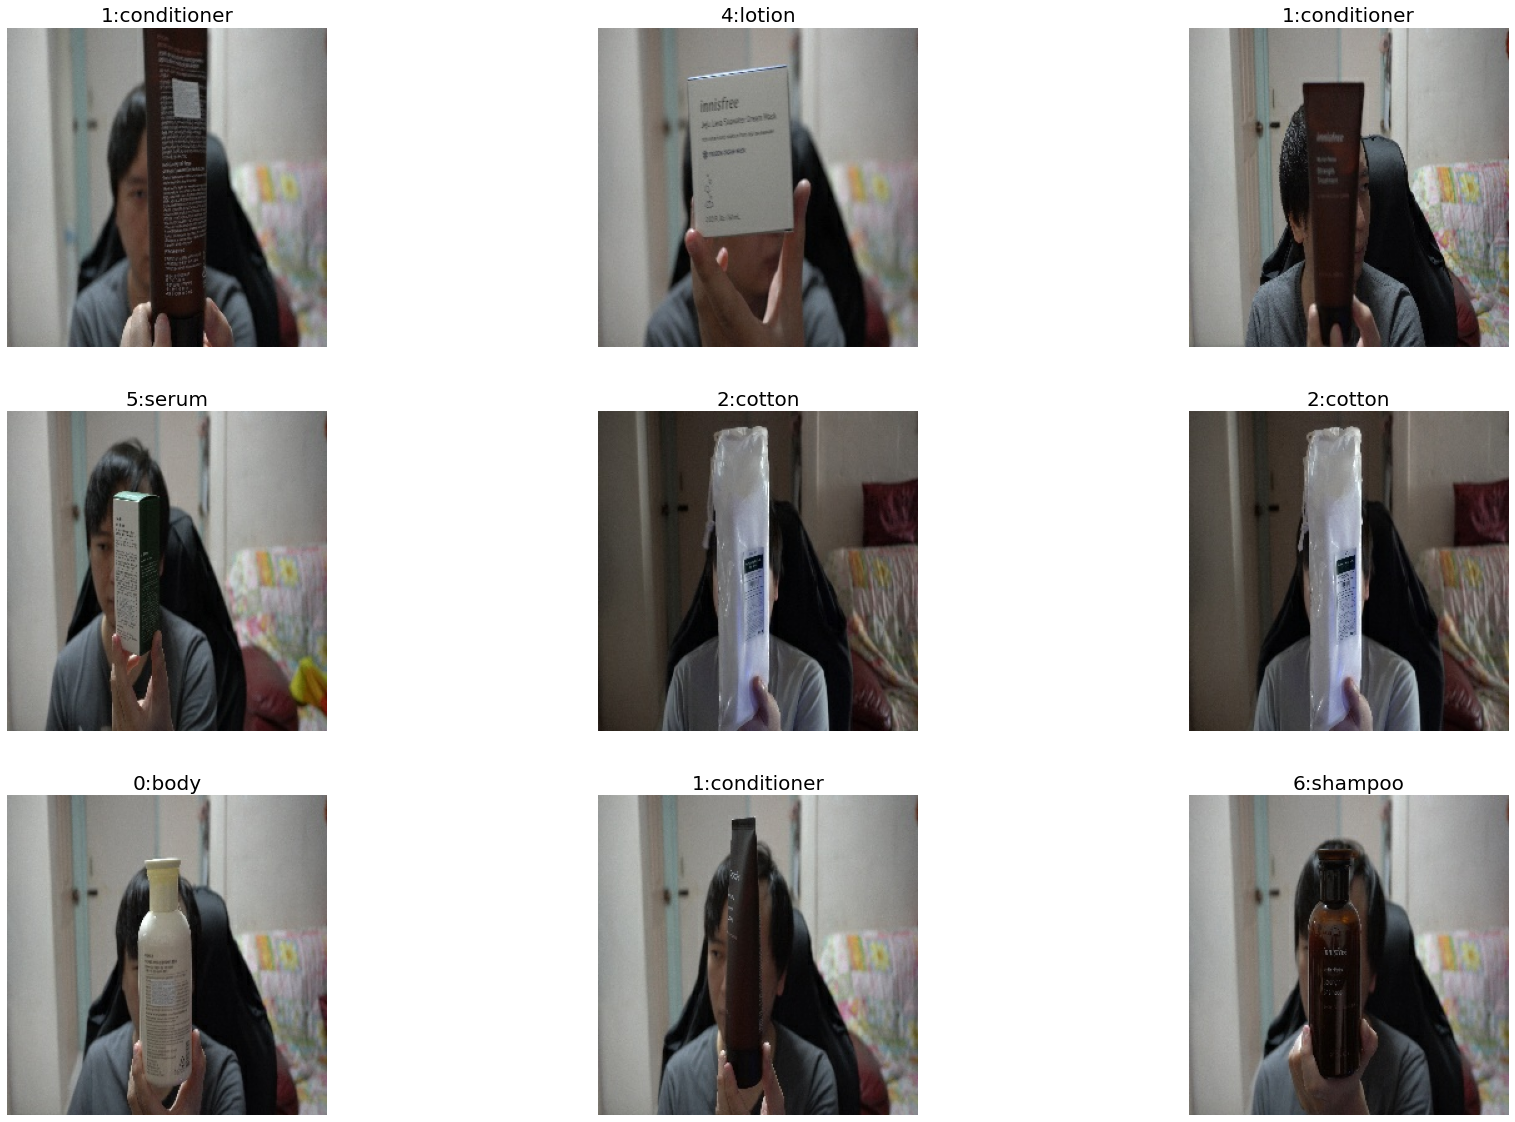

In [5]:
'''Color'''
plt.figure(figsize=(30, 20))
plt.rcParams['axes.titlesize'] = 20
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'{int(labels[i])}:{class_names[(labels[i])]}')
        plt.axis("off")

# '''Grayscale'''        
# plt.figure(figsize=(30, 20))
# plt.rcParams['axes.titlesize'] = 20
# for images, labels in train_dataset.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(tf.squeeze(images[i].numpy().astype("uint8")), cmap='gray', vmin=0, vmax=255)
#         plt.title(f'{int(labels[i])}:{class_names[(labels[i])]}')
#         plt.axis("off")        

In [6]:
def check_predictions(i_type):
    counter = 0
    print(f'Predicting for: {i_type}')
    
    for file in os.listdir(f'../test_predictions/{i_type}'):
        if file == '.gitkeep':
            continue
        img = keras.preprocessing.image.load_img(path=os.path.join(f'../test_predictions/{i_type}/', file), 
                                            color_mode='rgb',
                                            target_size=(img_height, img_width))
        img_arr = keras.preprocessing.image.img_to_array(img)
        img_arr = tf.expand_dims(img_arr, 0)
        pred = model.predict(img_arr)
        scores = tf.nn.softmax(pred[0])
        pred_class = np.argmax(scores)
        if class_names[pred_class] != i_type:
            counter += 1
            print(f'Predicted: {class_names[pred_class]} for: {file}')
            
    print(f'Number of misclassifications: {counter}')

In [7]:
def create_model():
    num_classes = len(class_names)

    model = Sequential([
        layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical', seed=random_seed),
        layers.experimental.preprocessing.RandomRotation(factor=0.3, seed=random_seed),
        layers.experimental.preprocessing.RandomZoom(height_factor=0.3, width_factor=0.3, seed=random_seed),
        layers.BatchNormalization(),
        
        # Conv 1
        layers.Conv2D(64, (3,3), activation='relu', padding='same', 
                      kernel_initializer=tf.keras.initializers.GlorotNormal(seed=random_seed)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same', 
                      kernel_initializer=tf.keras.initializers.GlorotNormal(seed=random_seed)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2,2)),

        # Conv 2
        layers.Conv2D(128, (3,3), activation='relu', padding='same', 
                      kernel_initializer=tf.keras.initializers.GlorotNormal(seed=random_seed)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same', 
                      kernel_initializer=tf.keras.initializers.GlorotNormal(seed=random_seed)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2,2)),
        
        # Conv 3
        layers.Conv2D(256, (3,3), activation='relu', padding='same', 
                      kernel_initializer=tf.keras.initializers.GlorotNormal(seed=random_seed)),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), activation='relu', padding='same', 
                      kernel_initializer=tf.keras.initializers.GlorotNormal(seed=random_seed)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2,2)),

        # Conv 4
        layers.Conv2D(512, (3,3), activation='relu', padding='same', 
                      kernel_initializer=tf.keras.initializers.GlorotNormal(seed=random_seed)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2,2)),

        # Conv 5
        layers.Conv2D(512, (3,3), activation='relu', padding='same', 
                      kernel_initializer=tf.keras.initializers.GlorotNormal(seed=random_seed)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2,2)),

        layers.Flatten(),
        layers.Dropout(0.3, seed=random_seed),
        layers.Dense(32, activation='relu'), # 32
        layers.BatchNormalization(),
        layers.Dropout(0.4, seed=random_seed), #.15
        layers.Dense(num_classes)])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])

    return model

##### Stratified Kfold

In [10]:
from sklearn.model_selection import StratifiedKFold

In [11]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)

In [12]:
x = train_dataset.take(-1)

In [13]:
data, labels = [], []

for images, targets in x:
    for i in range(len(images)):
        data.append(images[i].numpy())
        labels.append(targets[i].numpy())
        
data = np.array(data)        
labels = np.array(labels)        

In [14]:
avg_val_loss, avg_val_acc, eval_loss, eval_acc = [], [], [], []
time_taken = []

for f, (train_idx, test_idx) in enumerate(folds.split(data, labels)):
    start = time.time()
    fold = f+1
    print(f'Fold: {fold}')
#     print(f'Train Dataset size: {len(train_idx)}, Val Dataset Size: {len(test_idx)}')
    
    model = create_model()
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0, 
                                              patience=10, 
                                              verbose=1, 
                                              mode='min',
                                              baseline=None, 
                                              restore_best_weights=False)
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'./{fold}_glorot_best_model.h5', 
                                                monitor='val_loss', 
                                                verbose=1,
                                                save_best_only=True, 
                                                mode='min')
    epochs = 1000

    history = model.fit(x=data[train_idx], 
                        y=labels[train_idx],
#                         validation_split=split_ratio,
                        validation_data=(data[test_idx], labels[test_idx]),
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1, callbacks=[early_stop, checkpoint])
    
    avg_val_loss.append(np.mean(history.history['val_loss']))
    avg_val_acc.append(np.mean(history.history['val_sparse_categorical_accuracy']))
    
    model = load_model(f'./{fold}_glorot_best_model.h5')
    eval_res = model.evaluate(test_dataset, return_dict=True)
    eval_loss.append(eval_res['loss'])
    eval_acc.append(eval_res['sparse_categorical_accuracy'])

    print('*'*100)
    print(f'End of fold: {fold}')
    print(f'Time taken: {time.time() - start} seconds')
    time_taken.append(time.time() - start)
    print('*'*100)
    print('\n')
    
print(f'Total time taken: {sum(time_taken)}')    

Fold: 1
Epoch 1/1000
202/202 [==============================] - 61s 243ms/step - loss: 2.4083 - sparse_categorical_accuracy: 0.2138 - val_loss: 2.1389 - val_sparse_categorical_accuracy: 0.1885

Epoch 00001: val_loss improved from inf to 2.13888, saving model to .\1_glorot_best_model.h5
Epoch 2/1000
202/202 [==============================] - 40s 199ms/step - loss: 1.5150 - sparse_categorical_accuracy: 0.4835 - val_loss: 1.6066 - val_sparse_categorical_accuracy: 0.3841

Epoch 00002: val_loss improved from 2.13888 to 1.60661, saving model to .\1_glorot_best_model.h5
Epoch 3/1000
202/202 [==============================] - 41s 204ms/step - loss: 1.1303 - sparse_categorical_accuracy: 0.6178 - val_loss: 0.8077 - val_sparse_categorical_accuracy: 0.7318

Epoch 00003: val_loss improved from 1.60661 to 0.80769, saving model to .\1_glorot_best_model.h5
Epoch 4/1000
202/202 [==============================] - 42s 205ms/step - loss: 0.8940 - sparse_categorical_accuracy: 0.7051 - val_loss: 0.6830 - va


Epoch 00031: val_loss improved from 0.08730 to 0.07684, saving model to .\1_glorot_best_model.h5
Epoch 32/1000
202/202 [==============================] - 41s 201ms/step - loss: 0.0917 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.1053 - val_sparse_categorical_accuracy: 0.9777

Epoch 00032: val_loss did not improve from 0.07684
Epoch 33/1000
202/202 [==============================] - 41s 203ms/step - loss: 0.0796 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.0656 - val_sparse_categorical_accuracy: 0.9916

Epoch 00033: val_loss improved from 0.07684 to 0.06557, saving model to .\1_glorot_best_model.h5
Epoch 34/1000
202/202 [==============================] - 41s 204ms/step - loss: 0.0816 - sparse_categorical_accuracy: 0.9893 - val_loss: 0.0831 - val_sparse_categorical_accuracy: 0.9846

Epoch 00034: val_loss did not improve from 0.06557
Epoch 35/1000
202/202 [==============================] - 41s 205ms/step - loss: 0.0766 - sparse_categorical_accuracy: 0.9898 - val_loss: 0.076

202/202 [==============================] - 42s 210ms/step - loss: 0.1451 - sparse_categorical_accuracy: 0.9761 - val_loss: 0.1265 - val_sparse_categorical_accuracy: 0.9735

Epoch 00022: val_loss improved from 0.16562 to 0.12645, saving model to .\2_glorot_best_model.h5
Epoch 23/1000
202/202 [==============================] - 40s 197ms/step - loss: 0.1378 - sparse_categorical_accuracy: 0.9762 - val_loss: 0.1438 - val_sparse_categorical_accuracy: 0.9609

Epoch 00023: val_loss did not improve from 0.12645
Epoch 24/1000
202/202 [==============================] - 40s 198ms/step - loss: 0.1279 - sparse_categorical_accuracy: 0.9783 - val_loss: 0.1899 - val_sparse_categorical_accuracy: 0.9483

Epoch 00024: val_loss did not improve from 0.12645
Epoch 25/1000
202/202 [==============================] - 41s 201ms/step - loss: 0.1248 - sparse_categorical_accuracy: 0.9805 - val_loss: 0.1659 - val_sparse_categorical_accuracy: 0.9511

Epoch 00025: val_loss did not improve from 0.12645
Epoch 26/1000
20


Epoch 00015: val_loss did not improve from 0.18825
Epoch 16/1000
202/202 [==============================] - 41s 202ms/step - loss: 0.2406 - sparse_categorical_accuracy: 0.9507 - val_loss: 0.1741 - val_sparse_categorical_accuracy: 0.9637

Epoch 00016: val_loss improved from 0.18825 to 0.17411, saving model to .\3_glorot_best_model.h5
Epoch 17/1000
202/202 [==============================] - 42s 207ms/step - loss: 0.2133 - sparse_categorical_accuracy: 0.9605 - val_loss: 0.1599 - val_sparse_categorical_accuracy: 0.9665

Epoch 00017: val_loss improved from 0.17411 to 0.15994, saving model to .\3_glorot_best_model.h5
Epoch 18/1000
202/202 [==============================] - 41s 204ms/step - loss: 0.2021 - sparse_categorical_accuracy: 0.9664 - val_loss: 0.1592 - val_sparse_categorical_accuracy: 0.9707

Epoch 00018: val_loss improved from 0.15994 to 0.15915, saving model to .\3_glorot_best_model.h5
Epoch 19/1000
202/202 [==============================] - 42s 206ms/step - loss: 0.1901 - sparse_


Epoch 00047: val_loss did not improve from 0.03439
Epoch 48/1000
202/202 [==============================] - 42s 208ms/step - loss: 0.0480 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.0408 - val_sparse_categorical_accuracy: 0.9930

Epoch 00048: val_loss did not improve from 0.03439
Epoch 49/1000
202/202 [==============================] - 41s 202ms/step - loss: 0.0477 - sparse_categorical_accuracy: 0.9958 - val_loss: 0.0395 - val_sparse_categorical_accuracy: 0.9902

Epoch 00049: val_loss did not improve from 0.03439
Epoch 50/1000
202/202 [==============================] - 41s 201ms/step - loss: 0.0457 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0429 - val_sparse_categorical_accuracy: 0.9958

Epoch 00050: val_loss did not improve from 0.03439
Epoch 51/1000
202/202 [==============================] - 38s 188ms/step - loss: 0.0423 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.0278 - val_sparse_categorical_accuracy: 0.9972

Epoch 00051: val_loss improved from 0.03439 to 

202/202 [==============================] - 39s 193ms/step - loss: 0.0188 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.0127 - val_sparse_categorical_accuracy: 1.0000

Epoch 00081: val_loss improved from 0.01334 to 0.01269, saving model to .\3_glorot_best_model.h5
Epoch 82/1000
202/202 [==============================] - 39s 192ms/step - loss: 0.0201 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.0104 - val_sparse_categorical_accuracy: 1.0000

Epoch 00082: val_loss improved from 0.01269 to 0.01040, saving model to .\3_glorot_best_model.h5
Epoch 83/1000
202/202 [==============================] - 42s 206ms/step - loss: 0.0196 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.0630 - val_sparse_categorical_accuracy: 0.9832

Epoch 00083: val_loss did not improve from 0.01040
Epoch 84/1000
202/202 [==============================] - 42s 207ms/step - loss: 0.0163 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.0158 - val_sparse_categorical_accuracy: 1.0000

Epoch 00084: val_loss

202/202 [==============================] - 45s 224ms/step - loss: 1.1317 - sparse_categorical_accuracy: 0.6125 - val_loss: 0.8810 - val_sparse_categorical_accuracy: 0.7332

Epoch 00003: val_loss improved from 1.57715 to 0.88101, saving model to .\4_glorot_best_model.h5
Epoch 4/1000
202/202 [==============================] - 46s 225ms/step - loss: 0.9115 - sparse_categorical_accuracy: 0.7022 - val_loss: 0.6425 - val_sparse_categorical_accuracy: 0.7975

Epoch 00004: val_loss improved from 0.88101 to 0.64250, saving model to .\4_glorot_best_model.h5
Epoch 5/1000
202/202 [==============================] - 40s 199ms/step - loss: 0.7717 - sparse_categorical_accuracy: 0.7608 - val_loss: 0.5734 - val_sparse_categorical_accuracy: 0.8226

Epoch 00005: val_loss improved from 0.64250 to 0.57343, saving model to .\4_glorot_best_model.h5
Epoch 6/1000
202/202 [==============================] - 44s 216ms/step - loss: 0.6312 - sparse_categorical_accuracy: 0.8139 - val_loss: 0.4541 - val_sparse_categori

202/202 [==============================] - 41s 204ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.0245 - val_sparse_categorical_accuracy: 0.9972

Epoch 00065: val_loss did not improve from 0.02408
Epoch 66/1000
202/202 [==============================] - 40s 199ms/step - loss: 0.0333 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.0172 - val_sparse_categorical_accuracy: 0.9986

Epoch 00066: val_loss improved from 0.02408 to 0.01719, saving model to .\4_glorot_best_model.h5
Epoch 67/1000
202/202 [==============================] - 40s 198ms/step - loss: 0.0266 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.0296 - val_sparse_categorical_accuracy: 0.9958

Epoch 00067: val_loss did not improve from 0.01719
Epoch 68/1000
202/202 [==============================] - 39s 193ms/step - loss: 0.0245 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0357 - val_sparse_categorical_accuracy: 0.9958

Epoch 00068: val_loss did not improve from 0.01719
Epoch 69/1000
20


Epoch 00018: val_loss did not improve from 0.21507
Epoch 19/1000
202/202 [==============================] - 32s 160ms/step - loss: 0.2003 - sparse_categorical_accuracy: 0.9619 - val_loss: 0.1894 - val_sparse_categorical_accuracy: 0.9525

Epoch 00019: val_loss improved from 0.21507 to 0.18937, saving model to .\5_glorot_best_model.h5
Epoch 20/1000
202/202 [==============================] - 33s 164ms/step - loss: 0.1830 - sparse_categorical_accuracy: 0.9696 - val_loss: 0.1919 - val_sparse_categorical_accuracy: 0.9525

Epoch 00020: val_loss did not improve from 0.18937
Epoch 21/1000
202/202 [==============================] - 33s 162ms/step - loss: 0.1736 - sparse_categorical_accuracy: 0.9719 - val_loss: 0.1549 - val_sparse_categorical_accuracy: 0.9665

Epoch 00021: val_loss improved from 0.18937 to 0.15495, saving model to .\5_glorot_best_model.h5
Epoch 22/1000
202/202 [==============================] - 32s 160ms/step - loss: 0.1599 - sparse_categorical_accuracy: 0.9775 - val_loss: 0.158


Epoch 00050: val_loss did not improve from 0.03330
Epoch 51/1000
202/202 [==============================] - 39s 195ms/step - loss: 0.0520 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0337 - val_sparse_categorical_accuracy: 0.9986

Epoch 00051: val_loss did not improve from 0.03330
Epoch 52/1000
202/202 [==============================] - 38s 189ms/step - loss: 0.0436 - sparse_categorical_accuracy: 0.9957 - val_loss: 0.0622 - val_sparse_categorical_accuracy: 0.9846

Epoch 00052: val_loss did not improve from 0.03330
Epoch 53/1000
202/202 [==============================] - 38s 188ms/step - loss: 0.0459 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.0469 - val_sparse_categorical_accuracy: 0.9930

Epoch 00053: val_loss did not improve from 0.03330
Epoch 54/1000
202/202 [==============================] - 38s 188ms/step - loss: 0.0437 - sparse_categorical_accuracy: 0.9955 - val_loss: 0.0467 - val_sparse_categorical_accuracy: 0.9888

Epoch 00054: val_loss did not improve from 0.03

202/202 [==============================] - 38s 190ms/step - loss: 0.0799 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.0677 - val_sparse_categorical_accuracy: 0.9846

Epoch 00036: val_loss improved from 0.07076 to 0.06767, saving model to .\6_glorot_best_model.h5
Epoch 37/1000
202/202 [==============================] - 38s 187ms/step - loss: 0.0770 - sparse_categorical_accuracy: 0.9922 - val_loss: 0.0780 - val_sparse_categorical_accuracy: 0.9888

Epoch 00037: val_loss did not improve from 0.06767
Epoch 38/1000
202/202 [==============================] - 37s 183ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.0599 - val_sparse_categorical_accuracy: 0.9888

Epoch 00038: val_loss improved from 0.06767 to 0.05989, saving model to .\6_glorot_best_model.h5
Epoch 39/1000
202/202 [==============================] - 38s 187ms/step - loss: 0.0692 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.0702 - val_sparse_categorical_accuracy: 0.9874

Epoch 00039: val_loss


Epoch 00068: val_loss did not improve from 0.02338
Epoch 69/1000
202/202 [==============================] - 41s 201ms/step - loss: 0.0226 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0253 - val_sparse_categorical_accuracy: 0.9986

Epoch 00069: val_loss did not improve from 0.02338
Epoch 70/1000
202/202 [==============================] - 40s 197ms/step - loss: 0.0244 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0310 - val_sparse_categorical_accuracy: 0.9972

Epoch 00070: val_loss did not improve from 0.02338
Epoch 71/1000
202/202 [==============================] - 40s 200ms/step - loss: 0.0311 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.0418 - val_sparse_categorical_accuracy: 0.9930

Epoch 00071: val_loss did not improve from 0.02338
Epoch 72/1000
202/202 [==============================] - 40s 199ms/step - loss: 0.0259 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0267 - val_sparse_categorical_accuracy: 0.9958

Epoch 00072: val_loss did not improve from 0.02

202/202 [==============================] - 38s 188ms/step - loss: 0.3354 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.3119 - val_sparse_categorical_accuracy: 0.9232

Epoch 00013: val_loss improved from 0.31895 to 0.31190, saving model to .\7_glorot_best_model.h5
Epoch 14/1000
202/202 [==============================] - 38s 189ms/step - loss: 0.3032 - sparse_categorical_accuracy: 0.9339 - val_loss: 0.2672 - val_sparse_categorical_accuracy: 0.9372

Epoch 00014: val_loss improved from 0.31190 to 0.26717, saving model to .\7_glorot_best_model.h5
Epoch 15/1000
202/202 [==============================] - 37s 183ms/step - loss: 0.2779 - sparse_categorical_accuracy: 0.9468 - val_loss: 0.2806 - val_sparse_categorical_accuracy: 0.9190

Epoch 00015: val_loss did not improve from 0.26717
Epoch 16/1000
202/202 [==============================] - 38s 189ms/step - loss: 0.2700 - sparse_categorical_accuracy: 0.9402 - val_loss: 0.3052 - val_sparse_categorical_accuracy: 0.9148

Epoch 00016: val_loss

202/202 [==============================] - 33s 161ms/step - loss: 0.0268 - sparse_categorical_accuracy: 0.9983 - val_loss: 0.0244 - val_sparse_categorical_accuracy: 0.9986

Epoch 00077: val_loss did not improve from 0.01468
Epoch 78/1000
202/202 [==============================] - 33s 162ms/step - loss: 0.0316 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.0320 - val_sparse_categorical_accuracy: 0.9972

Epoch 00078: val_loss did not improve from 0.01468
Epoch 79/1000
202/202 [==============================] - 42s 209ms/step - loss: 0.0304 - sparse_categorical_accuracy: 0.9964 - val_loss: 0.0353 - val_sparse_categorical_accuracy: 0.9944

Epoch 00079: val_loss did not improve from 0.01468
Epoch 80/1000
202/202 [==============================] - 45s 222ms/step - loss: 0.0206 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.0184 - val_sparse_categorical_accuracy: 0.9986

Epoch 00080: val_loss did not improve from 0.01468
Epoch 81/1000
202/202 [==============================] - 41s 2

202/202 [==============================] - 40s 198ms/step - loss: 0.0394 - sparse_categorical_accuracy: 0.9966 - val_loss: 0.0424 - val_sparse_categorical_accuracy: 0.9944

Epoch 00055: val_loss did not improve from 0.03050
Epoch 56/1000
202/202 [==============================] - 40s 199ms/step - loss: 0.0420 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0453 - val_sparse_categorical_accuracy: 0.9874

Epoch 00056: val_loss did not improve from 0.03050
Epoch 57/1000
202/202 [==============================] - 41s 204ms/step - loss: 0.0379 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.0278 - val_sparse_categorical_accuracy: 0.9986

Epoch 00057: val_loss improved from 0.03050 to 0.02778, saving model to .\8_glorot_best_model.h5
Epoch 58/1000
202/202 [==============================] - 40s 200ms/step - loss: 0.0340 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.0267 - val_sparse_categorical_accuracy: 0.9958

Epoch 00058: val_loss improved from 0.02778 to 0.02667, saving mode

202/202 [==============================] - 42s 207ms/step - loss: 0.0210 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.0141 - val_sparse_categorical_accuracy: 1.0000

Epoch 00088: val_loss did not improve from 0.01180
Epoch 89/1000
202/202 [==============================] - 42s 210ms/step - loss: 0.0167 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.0124 - val_sparse_categorical_accuracy: 1.0000

Epoch 00089: val_loss did not improve from 0.01180
Epoch 90/1000
202/202 [==============================] - 41s 204ms/step - loss: 0.0194 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.0158 - val_sparse_categorical_accuracy: 0.9972

Epoch 00090: val_loss did not improve from 0.01180
Epoch 91/1000
202/202 [==============================] - 41s 202ms/step - loss: 0.0160 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0179 - val_sparse_categorical_accuracy: 0.9986

Epoch 00091: val_loss did not improve from 0.01180
Epoch 00091: early stopping
53/53 [===========================

202/202 [==============================] - 38s 189ms/step - loss: 0.1156 - sparse_categorical_accuracy: 0.9849 - val_loss: 0.0761 - val_sparse_categorical_accuracy: 0.9930

Epoch 00026: val_loss improved from 0.07698 to 0.07614, saving model to .\9_glorot_best_model.h5
Epoch 27/1000
202/202 [==============================] - 39s 193ms/step - loss: 0.1061 - sparse_categorical_accuracy: 0.9857 - val_loss: 0.0788 - val_sparse_categorical_accuracy: 0.9916

Epoch 00027: val_loss did not improve from 0.07614
Epoch 28/1000
202/202 [==============================] - 40s 196ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.9831 - val_loss: 0.1188 - val_sparse_categorical_accuracy: 0.9762

Epoch 00028: val_loss did not improve from 0.07614
Epoch 29/1000
202/202 [==============================] - 39s 192ms/step - loss: 0.0972 - sparse_categorical_accuracy: 0.9872 - val_loss: 0.0758 - val_sparse_categorical_accuracy: 0.9874

Epoch 00029: val_loss improved from 0.07614 to 0.07583, saving mode

202/202 [==============================] - 34s 169ms/step - loss: 0.3146 - sparse_categorical_accuracy: 0.9347 - val_loss: 0.3270 - val_sparse_categorical_accuracy: 0.9329

Epoch 00013: val_loss improved from 0.36057 to 0.32701, saving model to .\10_glorot_best_model.h5
Epoch 14/1000
202/202 [==============================] - 34s 169ms/step - loss: 0.3093 - sparse_categorical_accuracy: 0.9330 - val_loss: 0.3001 - val_sparse_categorical_accuracy: 0.9315

Epoch 00014: val_loss improved from 0.32701 to 0.30009, saving model to .\10_glorot_best_model.h5
Epoch 15/1000
202/202 [==============================] - 34s 169ms/step - loss: 0.2782 - sparse_categorical_accuracy: 0.9421 - val_loss: 0.2762 - val_sparse_categorical_accuracy: 0.9441

Epoch 00015: val_loss improved from 0.30009 to 0.27616, saving model to .\10_glorot_best_model.h5
Epoch 16/1000
202/202 [==============================] - 34s 169ms/step - loss: 0.2575 - sparse_categorical_accuracy: 0.9563 - val_loss: 0.2772 - val_sparse_ca

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



202/202 [==============================] - 34s 169ms/step - loss: 0.0220 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.0100 - val_sparse_categorical_accuracy: 1.0000

Epoch 00079: val_loss improved from 0.01233 to 0.01004, saving model to .\10_glorot_best_model.h5
Epoch 80/1000
202/202 [==============================] - 34s 169ms/step - loss: 0.0191 - sparse_categorical_accuracy: 0.9996 - val_loss: 0.0099 - val_sparse_categorical_accuracy: 1.0000

Epoch 00080: val_loss improved from 0.01004 to 0.00989, saving model to .\10_glorot_best_model.h5
Epoch 81/1000
202/202 [==============================] - 34s 169ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.0309 - val_sparse_categorical_accuracy: 0.9916

Epoch 00081: val_loss did not improve from 0.00989
Epoch 82/1000
202/202 [==============================] - 34s 169ms/step - loss: 0.0205 - sparse_categorical_accuracy: 0.9987 - val_loss: 0.0091 - val_sparse_categorical_accuracy: 0.9986

Epoch 00082: val_lo

In [15]:
for i in range(len(avg_val_loss)):
    print('*'*100)
    print(f'Fold: {i+1}')
    print(f'Avg Val Loss: {round(avg_val_loss[i], ndigits=3)}')
    print(f'Avg Val Acc: {round(avg_val_acc[i]*100, ndigits=3)}')
    print(f'Eval Loss: {round(eval_loss[i], ndigits=3)}')
    print(f'Eval Acc: {round(eval_acc[i]*100, ndigits=3)}')

****************************************************************************************************
Fold: 1
Avg Val Loss: 0.182
Avg Val Acc: 94.933
Eval Loss: 0.038
Eval Acc: 99.58
****************************************************************************************************
Fold: 2
Avg Val Loss: 0.373
Avg Val Acc: 88.703
Eval Loss: 0.18
Eval Acc: 95.255
****************************************************************************************************
Fold: 3
Avg Val Loss: 0.123
Avg Val Acc: 96.666
Eval Loss: 0.017
Eval Acc: 99.82
****************************************************************************************************
Fold: 4
Avg Val Loss: 0.166
Avg Val Acc: 95.806
Eval Loss: 0.034
Eval Acc: 99.64
****************************************************************************************************
Fold: 5
Avg Val Loss: 0.191
Avg Val Acc: 94.662
Eval Loss: 0.036
Eval Acc: 99.459
*****************************************************************************************

In [16]:
print('*'*100)
print(f'Final Avg Loss: {round(np.mean(avg_val_loss), ndigits=3)} (+/-{round(np.std(avg_val_loss), ndigits=3)})') 
print(f'Final Avg Val Acc: {round(np.mean(avg_val_acc), ndigits=3)} (+/-{round(np.std(avg_val_acc), ndigits=3)})')
print(f'Final Eval Loss: {round(np.mean(eval_loss), ndigits=3)} (+/-{round(np.std(eval_loss), ndigits=3)})')
print(f'Final Eval Acc: {round(np.mean(eval_acc), ndigits=3)} (+/-{round(np.std(eval_acc), ndigits=3)})')

****************************************************************************************************
Final Avg Loss: 0.189 (+/-0.065)
Final Avg Val Acc: 0.947 (+/-0.021)
Final Eval Loss: 0.042 (+/-0.046)
Final Eval Acc: 0.992 (+/-0.013)


##### Full training

In [10]:
results_df = pd.DataFrame({'results':[61,26,99,66,67,76,73,81,68,82]})

In [11]:
results_df.describe()

,results
count,10.000000
mean,69.900000
std,18.847045
min,26.000000
25%,66.250000
50%,70.500000
75%,79.750000
max,99.000000


In [12]:
results_df.quantile(q=0.95)

results    91.35
Name: 0.95, dtype: float64

<AxesSubplot:>

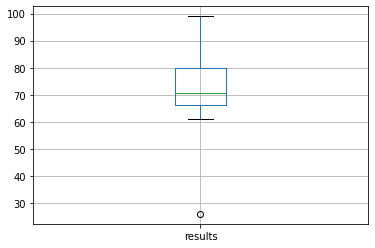

In [13]:
results_df.boxplot()

In [8]:
train_num_batches = train_dataset.cardinality().numpy()
# val_num_batches = val_dataset.cardinality().numpy()

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(buffer_size=(train_num_batches*batch_size), seed=random_seed).prefetch(buffer_size=AUTOTUNE)
# val_dataset = val_dataset.cache().shuffle(buffer_size=(val_num_batches*batch_size), seed=random_seed).prefetch(buffer_size=AUTOTUNE)

In [9]:
model = create_model()

In [10]:
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                               min_delta=0, 
#                                               patience=10, 
#                                               verbose=1, 
#                                               mode='min',
#                                               baseline=None, 
#                                               restore_best_weights=False)

In [11]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./glorot_best_model.h5', 
#                                                 monitor='val_loss',
#                                                 verbose=1,
#                                                 save_best_only=True, 
#                                                 mode='min')

In [12]:
# 50: 87.50
# 100: 89.21
# 150: 95.92
# 200: 96.05
# 250: 96.32 (96.97)
# 300: 98.95 (99.02)
# 350: 98.42 (98.20)
# 400: 97.37 (97.50)

epochs = 300

history = model.fit(train_dataset, 
#                     validation_data=val_dataset,
                    epochs=epochs,
                    verbose=1, 
#                     callbacks=[early_stop, checkpoint]
                   )

Epoch 1/300
77/77 [==============================] - 21s 161ms/step - loss: 2.5994 - sparse_categorical_accuracy: 0.2004
Epoch 2/300
77/77 [==============================] - 11s 147ms/step - loss: 1.7563 - sparse_categorical_accuracy: 0.3904
Epoch 3/300
77/77 [==============================] - 11s 147ms/step - loss: 1.4001 - sparse_categorical_accuracy: 0.4928
Epoch 4/300
77/77 [==============================] - 11s 147ms/step - loss: 1.2536 - sparse_categorical_accuracy: 0.5517
Epoch 5/300
77/77 [==============================] - 11s 148ms/step - loss: 1.0337 - sparse_categorical_accuracy: 0.6227
Epoch 6/300
77/77 [==============================] - 11s 147ms/step - loss: 0.9383 - sparse_categorical_accuracy: 0.6630
Epoch 7/300
77/77 [==============================] - 12s 153ms/step - loss: 0.7809 - sparse_categorical_accuracy: 0.7257
Epoch 8/300
77/77 [==============================] - 12s 159ms/step - loss: 0.7294 - sparse_categorical_accuracy: 0.7321
Epoch 9/300
77/77 [=============

Epoch 135/300
77/77 [==============================] - 12s 157ms/step - loss: 0.0409 - sparse_categorical_accuracy: 0.9998
Epoch 136/300
77/77 [==============================] - 12s 160ms/step - loss: 0.0333 - sparse_categorical_accuracy: 1.0000
Epoch 137/300
77/77 [==============================] - 12s 161ms/step - loss: 0.0336 - sparse_categorical_accuracy: 0.9990
Epoch 138/300
77/77 [==============================] - 12s 156ms/step - loss: 0.0326 - sparse_categorical_accuracy: 0.9993
Epoch 139/300
77/77 [==============================] - 12s 157ms/step - loss: 0.0388 - sparse_categorical_accuracy: 0.9989
Epoch 140/300
77/77 [==============================] - 12s 158ms/step - loss: 0.0339 - sparse_categorical_accuracy: 0.9999
Epoch 141/300
77/77 [==============================] - 12s 157ms/step - loss: 0.0329 - sparse_categorical_accuracy: 0.9987
Epoch 142/300
77/77 [==============================] - 12s 156ms/step - loss: 0.0358 - sparse_categorical_accuracy: 0.9993
Epoch 143/300
77

77/77 [==============================] - 11s 147ms/step - loss: 0.0116 - sparse_categorical_accuracy: 0.9993
Epoch 268/300
77/77 [==============================] - 11s 147ms/step - loss: 0.0118 - sparse_categorical_accuracy: 1.0000
Epoch 269/300
77/77 [==============================] - 11s 147ms/step - loss: 0.0126 - sparse_categorical_accuracy: 1.0000
Epoch 270/300
77/77 [==============================] - 11s 147ms/step - loss: 0.0106 - sparse_categorical_accuracy: 1.0000
Epoch 271/300
77/77 [==============================] - 11s 147ms/step - loss: 0.0103 - sparse_categorical_accuracy: 1.0000
Epoch 272/300
77/77 [==============================] - 11s 147ms/step - loss: 0.0126 - sparse_categorical_accuracy: 0.9996
Epoch 273/300
77/77 [==============================] - 11s 147ms/step - loss: 0.0098 - sparse_categorical_accuracy: 1.0000
Epoch 274/300
77/77 [==============================] - 11s 147ms/step - loss: 0.0117 - sparse_categorical_accuracy: 1.0000
Epoch 275/300
77/77 [=========

In [13]:
# history.history['sparse_categorical_accuracy'].index(1.)

In [14]:
# plt.figure(figsize=(30, 15))
# acc = history.history['sparse_categorical_accuracy']
# loss = history.history['loss']
# epochs_range = range(len(acc))

# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Accuracy')
# plt.plot(epochs_range, loss, label='Loss')
# plt.legend(loc='lower right')
# plt.title('Accuracy vs Loss')

In [15]:
# model.summary()

In [16]:
model.save('./full_train_model.h5')

In [17]:
# plt.figure(figsize=(30, 15))
# acc = history.history['sparse_categorical_accuracy']
# val_acc = history.history['val_sparse_categorical_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(len(acc))

# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [18]:
# sp_acc = history.history['sparse_categorical_accuracy']
# sp_loss = history.history['loss']
# val_acc = history.history['val_sparse_categorical_accuracy']
# val_loss = history.history['val_loss']

# print(f'Avg Acc: {round(np.mean(sp_acc), ndigits=4)} (+/-{round(np.std(sp_acc), ndigits=4)})')
# print(f'Avg Loss: {round(np.mean(sp_loss), ndigits=4)} (+/-{round(np.std(sp_loss), ndigits=4)})')
# print(f'Avg Val Acc: {round(np.mean(val_acc), ndigits=4)} (+/-{round(np.std(val_acc), ndigits=4)})')
# print(f'Avg Val Loss: {round(np.mean(val_loss), ndigits=4)} (+/-{round(np.std(val_loss), ndigits=4)})')

In [19]:
model = load_model('./full_train_model.h5')
# model = load_model('./glorot_best_model.h5')

In [20]:
# for images, labels in test_dataset.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         img_arr = keras.preprocessing.image.img_to_array(images[i])
#         plt.imshow(img_arr.astype("uint8"))
#         img_arr = tf.expand_dims(img_arr, 0)
#         pred = model.predict(img_arr)
#         scores = tf.nn.softmax(pred[0])
#         pred_class = np.argmax(scores)
#         print(f'Label: {class_names[labels[i]]}, Predicted: {class_names[pred_class]}')
#         plt.title(f'Predicted Class: {class_names[pred_class]}')

In [21]:
# keras.utils.plot_model(model, show_shapes=True)

In [22]:
print(class_names)

['body', 'conditioner', 'cotton', 'facial', 'lotion', 'serum', 'shampoo', 'toner']


In [23]:
# Train
print(model.evaluate(train_dataset, return_dict=True))

77/77 [==============================] - 3s 40ms/step - loss: 0.0068 - sparse_categorical_accuracy: 0.9984
{'loss': 0.006842801813036203, 'sparse_categorical_accuracy': 0.9983606338500977}


In [24]:
# Val
# print(model.evaluate(val_dataset, return_dict=True))

In [25]:
# Test
print(model.evaluate(test_dataset, return_dict=True))

24/24 [==============================] - 3s 131ms/step - loss: 0.0114 - sparse_categorical_accuracy: 1.0000
{'loss': 0.011363478377461433, 'sparse_categorical_accuracy': 1.0}


In [26]:
# plt.figure(figsize=(30, 20))
# plt.rcParams['axes.titlesize'] = 20
y_true, y_pred, y_pred_scores = [], [], []

for images, labels in test_dataset.take(-1):
    for i in range(len(labels)):
        y_true.append(labels[i])
        img_arr = keras.preprocessing.image.img_to_array(images[i])
        img_arr = tf.expand_dims(img_arr, 0)
        pred = model.predict(img_arr)
        scores = tf.nn.softmax(pred[0])
        pred_class = np.argmax(scores)
        y_pred.append(pred_class)
        y_pred_scores.append(scores)
        
#         ax = plt.subplot(3, 3, i + 1)
#         if labels[i] != pred_class:
#             print(f'item:{i+1}, y_true:{class_names[labels[i]]}, y_pred:{class_names[pred_class]}')
#             plt.imsave(fname=f'{i}-y_true-{class_names[labels[i]]}-y_pred-{class_names[pred_class]}.jpg',
#                        arr=images[i].numpy().astype("uint8"), 
#                        format='jpg')
#             plt.title(f'y_true:{class_names[labels[i]]}, y_pred:{class_names[pred_class]}')
#             plt.axis("off")
#         print(f'Label: {class_names[labels[i]]}, Predicted: {class_names[pred_class]}')

In [27]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

        body     1.0000    1.0000    1.0000        80
 conditioner     1.0000    1.0000    1.0000        80
      cotton     1.0000    1.0000    1.0000       120
      facial     1.0000    1.0000    1.0000        80
      lotion     1.0000    1.0000    1.0000        80
       serum     1.0000    1.0000    1.0000       160
     shampoo     1.0000    1.0000    1.0000        80
       toner     1.0000    1.0000    1.0000        80

    accuracy                         1.0000       760
   macro avg     1.0000    1.0000    1.0000       760
weighted avg     1.0000    1.0000    1.0000       760



<AxesSubplot:>

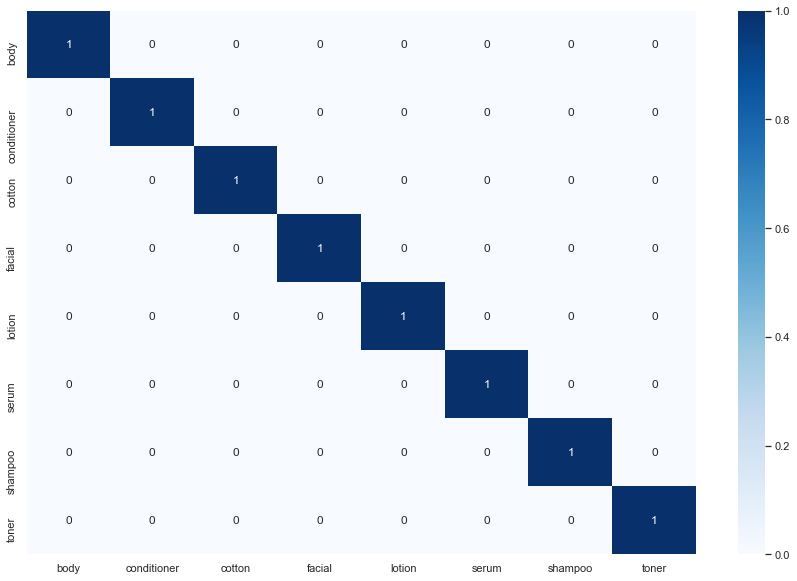

In [28]:
sns.set(rc={'figure.figsize':(15, 10)})

cm_normalized = pd.DataFrame(confusion_matrix(y_true, y_pred, normalize='true'), 
                             class_names, 
                             class_names,
                             dtype=float)
sns.heatmap(cm_normalized, annot=True, cmap='Blues')

<AxesSubplot:>

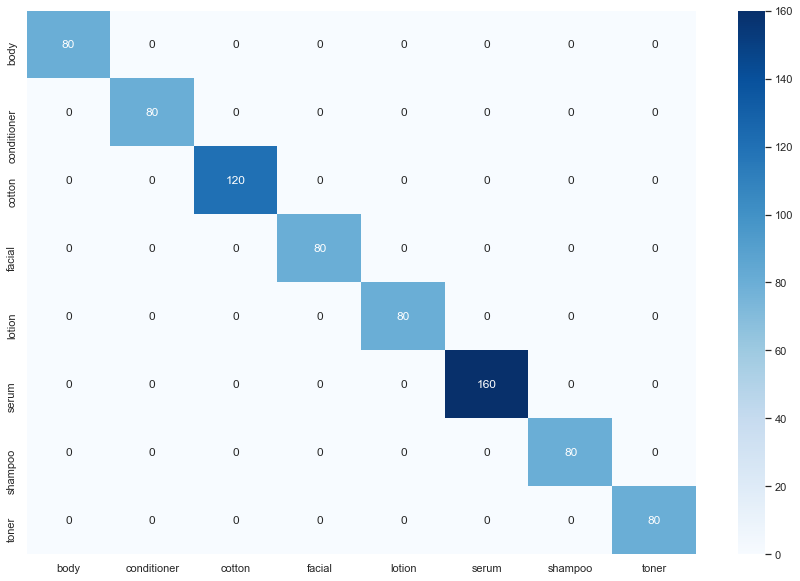

In [29]:
cm = pd.DataFrame(data=confusion_matrix(y_true, y_pred), 
                  index=class_names, 
                  columns=class_names)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

In [30]:
current_auc = roc_auc_score(y_true, y_pred_scores, multi_class='ovr', average='weighted')
best_auc = 0.9999832788371464 # 0.9999987218617872
print(f'Current AUC: {current_auc}, Best AUC: {best_auc}')    
print(current_auc > best_auc)

Current AUC: 1.0, Best AUC: 0.9999832788371464
True


In [31]:
for class_name in class_names:
    check_predictions(class_name)
    print('\n')
    print('*'*100)

Predicting for: body
Number of misclassifications: 0


****************************************************************************************************
Predicting for: conditioner
Number of misclassifications: 0


****************************************************************************************************
Predicting for: cotton
Number of misclassifications: 0


****************************************************************************************************
Predicting for: facial
Predicted: conditioner for: 2020-12-19-14-08-24-image.jpg
Predicted: conditioner for: 2020-12-19-14-08-25-image.jpg
Number of misclassifications: 2


****************************************************************************************************
Predicting for: lotion
Number of misclassifications: 0


****************************************************************************************************
Predicting for: serum
Number of misclassifications: 0


***********************************

##### DB

In [1]:
from db_model import db, app, Item
from sqlalchemy import func, create_engine

In [2]:
db.create_all()
engine = create_engine('sqlite:///../db/items.db')

In [27]:
a = 'conditioner'

with engine.connect() as con:
#     con.execute("""INSERT INTO Item (item_type, num_items) VALUES (?, 5)""", a)
    res = con.execute("""SELECT * from ITEM Where item_type = ?""", a)
    x = res.fetchall()

In [28]:
x

[(2, 'conditioner', 5, None)]

In [19]:
with engine.connect() as con:
    res = con.execute("""SELECT * FROM Item WHERE item_type = 'facial'""")
    print(res.fetchall())

[]


In [23]:
if res.fetchall():
    print('Have')
else:
    print('empty')

empty


In [34]:
with engine.connect() as con:
#     con.execute("""UPDATE Item SET num_items = Item.num_items + 10 WHERE Item.item_type = ?""", a)
    res = con.execute("""SELECT * from ITEM""")
    x = res.fetchall()

In [35]:
x

[(1, 'a', 5, None), (2, 'conditioner', 15, None)]